In [14]:
from util.get_data import get_features_and_targets
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
features, targets = get_features_and_targets()
features.head()

GENDER column transformed: [1 0]
EDUCATION_LEVEL column transformed: [2 1 3 4]
MARITAL_STATUS column transformed: [1 2 3]
CREDIT_LIMIT: 167 outliers capped.
AGE: 272 outliers capped.
SEPT_BILL: 2400 outliers capped.
AUG_BILL: 2395 outliers capped.
JULY_BILL: 2469 outliers capped.
JUNE_BILL: 2622 outliers capped.
MAY_BILL: 2725 outliers capped.
APRIL_BILL: 2693 outliers capped.
SEPT_PAYMENT: 2745 outliers capped.
AUG_PAYMENT: 2714 outliers capped.
JULY_PAYMENT: 2598 outliers capped.
JUNE_PAYMENT: 2994 outliers capped.
MAY_PAYMENT: 2945 outliers capped.
APRIL_PAYMENT: 2958 outliers capped.


,CREDIT_LIMIT,GENDER,EDUCATION_LEVEL,MARITAL_STATUS,AGE,SEPT_PAY_STATUS,AUG_PAY_STATUS,JULY_PAY_STATUS,JUNE_PAY_STATUS,MAY_PAY_STATUS,...,JULY_BILL,JUNE_BILL,MAY_BILL,APRIL_BILL,SEPT_PAYMENT,AUG_PAYMENT,JULY_PAYMENT,JUNE_PAYMENT,MAY_PAYMENT,APRIL_PAYMENT
0,20000,1,2,1,24.0,2,2,-1,-1,-2,...,689.0,0.0,0.0,0.0,0,689.0,0.0,0.0,0,0.0
1,120000,1,2,2,26.0,-1,2,0,0,0,...,2682.0,3272.0,3455.0,3261.0,0,1000.0,1000.0,1000.0,0,2000.0
2,90000,1,2,2,34.0,0,0,0,0,0,...,13559.0,14331.0,14948.0,15549.0,1518,1500.0,1000.0,1000.0,1000,5000.0
3,50000,1,2,1,37.0,0,0,0,0,0,...,49291.0,28314.0,28959.0,29547.0,2000,2019.0,1200.0,1100.0,1069,1000.0
4,50000,0,2,1,57.0,-1,0,-1,0,0,...,35835.0,20940.0,19146.0,19131.0,2000,11250.5,10000.0,9000.0,689,679.0


## XGBoost and Feature Selection

### Recursive Feature Elimination using Logistic Regression

In [16]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression(max_iter=1000, random_state=42)
rfe_logistic = RFE(estimator=logistic_model, n_features_to_select=1, step=1)
fit_logistic = rfe_logistic.fit(features, targets.values.ravel())

all_features_ranking = pd.DataFrame({
    'Feature': features.columns,
    'Ranking': fit_logistic.ranking_,
}).sort_values(by='Ranking')

all_features_ranking

/Users/alejandromarchini/.pyenv/versions/3.9.16/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/alejandromarchini/.pyenv/versions/3.9.16/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

,Feature,Ranking
5,SEPT_PAY_STATUS,1
7,JULY_PAY_STATUS,2
3,MARITAL_STATUS,3
1,GENDER,4
6,AUG_PAY_STATUS,5
9,MAY_PAY_STATUS,6
2,EDUCATION_LEVEL,7
8,JUNE_PAY_STATUS,8
4,AGE,9
10,APRIL_PAY_STATUS,10


### Baseline XGBoost with all features

Accuracy score using all features: 0.8168333333333333


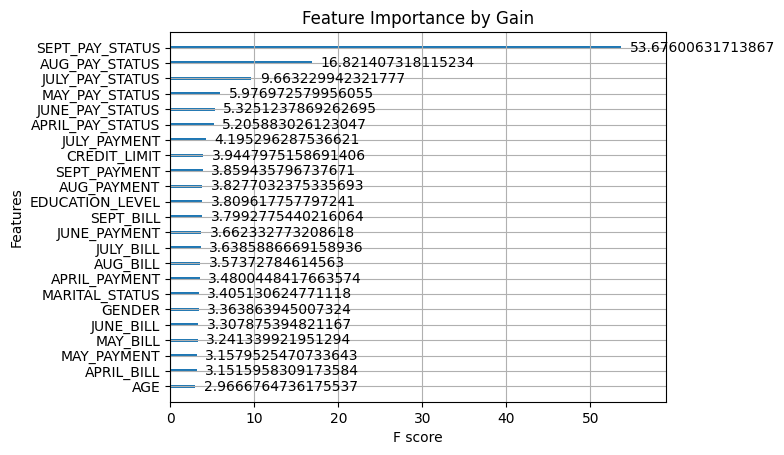

In [17]:
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

features_train, features_test, target_train, target_test = train_test_split(features, targets, test_size=0.2, random_state=42)
xgb_model_all_features = XGBClassifier(eval_metric='logloss')
xgb_model_all_features.fit(features_train, target_train)

pred = xgb_model_all_features.predict(features_test)
score = accuracy_score(target_test, pred)
print('Accuracy score using all features: {}'.format(score))
plot_importance(xgb_model_all_features, importance_type='gain')
plt.title('Feature Importance by Gain')
plt.show()

### XGBoost with top 10 features by Gain

Accuracy score using all features: 0.8106666666666666


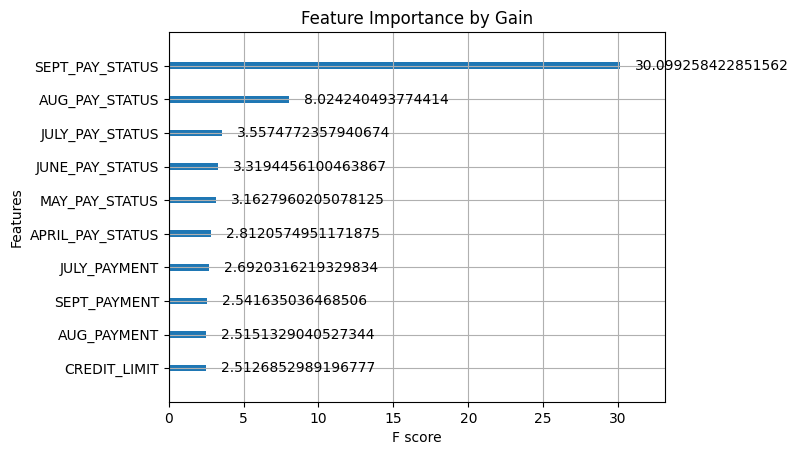

In [18]:
feature_importance = xgb_model_all_features.get_booster().get_score(importance_type='gain')
feature_importance_df = pd.DataFrame.from_dict(feature_importance, orient='index', columns=['Gain']).sort_values(by='Gain', ascending=False)
top_10_features = feature_importance_df.head(10).index.tolist()

xgb_model_top_10_features = XGBClassifier(eval_metric='logloss')
xgb_model_top_10_features.fit(features_train[top_10_features], target_train)

pred = xgb_model_top_10_features.predict(features_test[top_10_features])
score = accuracy_score(target_test, pred)
print('Accuracy score using all features: {}'.format(score))
plot_importance(xgb_model_top_10_features, importance_type='gain')
plt.title('Feature Importance by Gain')
plt.show()

### XGBoost without demographic data

Accuracy score using all features: 0.8145


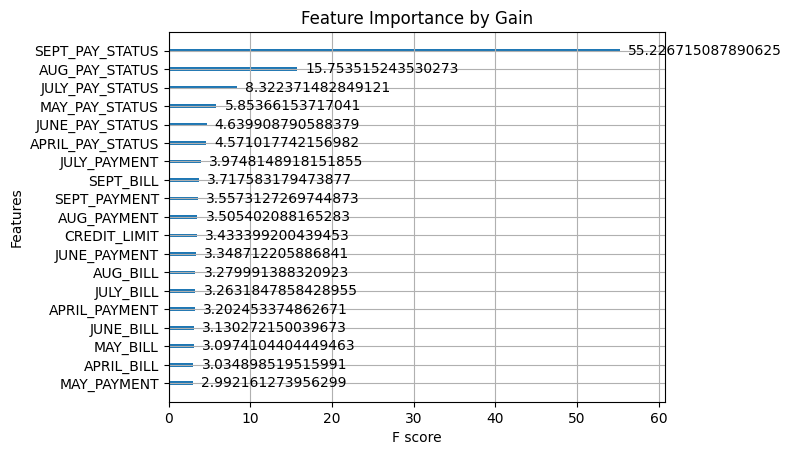

In [19]:
features_train_no_demographics = features_train.drop(['GENDER', 'AGE', 'EDUCATION_LEVEL', 'MARITAL_STATUS'], axis=1)
features_test_no_demographics = features_test.drop(['GENDER', 'AGE', 'EDUCATION_LEVEL', 'MARITAL_STATUS'], axis=1)

xgb_model_no_demographics = XGBClassifier(eval_metric='logloss')
xgb_model_no_demographics.fit(features_train_no_demographics, target_train)

pred = xgb_model_no_demographics.predict(features_test_no_demographics)
score = accuracy_score(target_test, pred)
print('Accuracy score using all features: {}'.format(score))
plot_importance(xgb_model_no_demographics, importance_type='gain')
plt.title('Feature Importance by Gain')
plt.show()

### Use only 3 most recent months in features

Accuracy score using all features: 0.8136666666666666


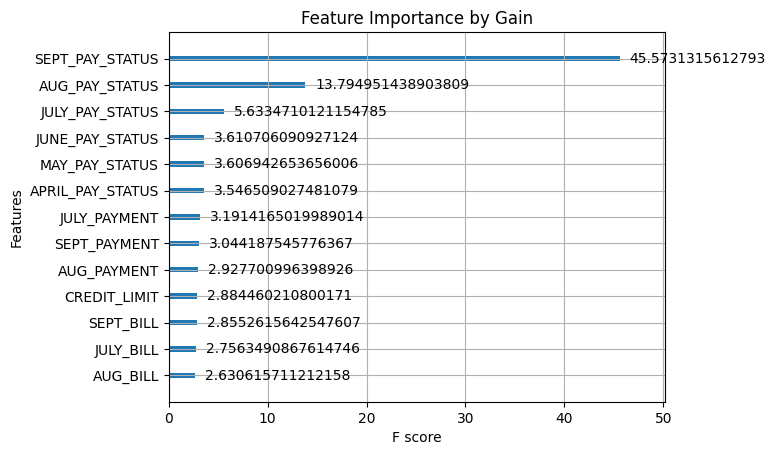

In [20]:
features_train_no_demo_most_recent = features_train_no_demographics.drop(['APRIL_BILL', 'APRIL_PAYMENT', 'MAY_BILL', 'MAY_PAYMENT', 'JUNE_BILL', 'JUNE_PAYMENT'], axis=1)
features_test_no_demo_most_recent = features_test_no_demographics.drop(['APRIL_BILL', 'APRIL_PAYMENT', 'MAY_BILL', 'MAY_PAYMENT', 'JUNE_BILL', 'JUNE_PAYMENT'], axis=1)


xgb_model_no_demo_most_recent = XGBClassifier(eval_metric='logloss')
xgb_model_no_demo_most_recent.fit(features_train_no_demo_most_recent, target_train)

pred = xgb_model_no_demo_most_recent.predict(features_test_no_demo_most_recent)
score = accuracy_score(target_test, pred)
print('Accuracy score using all features: {}'.format(score))
plot_importance(xgb_model_no_demo_most_recent, importance_type='gain')
plt.title('Feature Importance by Gain')
plt.show()